In [15]:
import gudhi as gd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

from matplotlib.pyplot import figure

from pygenstability import plotting
from pygenstability.optimal_scales import *
from pygenstability.pygenstability import evaluate_NVI

In [3]:
import sys
from pathlib import Path

module_path = str(Path.cwd().parents[0])
if module_path not in sys.path:
    sys.path.append(module_path)

from msfiltration import MSF

In [4]:
root_fig = '/home/tc/OneDrive/Software/MSFiltration/figures/'

In [14]:
plt.rcParams.update({'font.size': 20})

# Sample network from ER model

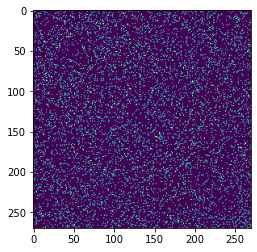

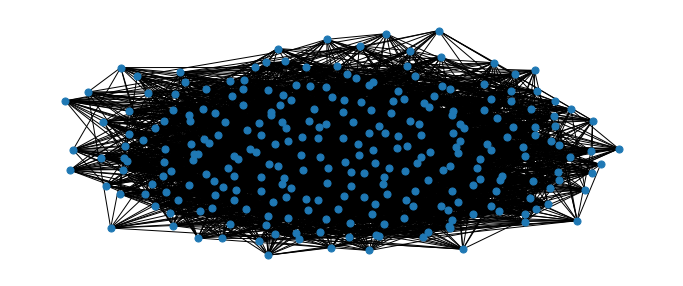

In [6]:
n = 270
m = 3473
seed = 20160 

# Use seed for reproducibility
G = nx.gnm_random_graph(n, m, seed=seed)

A = nx.adjacency_matrix(G).toarray()

# plot matrix
plt.figure()
plt.imshow(A)
#plt.savefig(root_fig +'adjacency_matrix.pdf', bbox_inches='tight')
plt.show()

# Compute spring layout
pos = nx.layout.spring_layout(G, seed=2)


# Plot graph
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
fig.subplots_adjust(hspace=0.4, wspace=0)

nx.draw(
    G,
    ax=ax,
    pos=pos,
    node_size=50,
    arrows=False,
    width=1,
)


# plt.savefig(root_fig +'Multiscale_Structure.pdf', dpi=fig.dpi,bbox_inches='tight')

In [7]:
G.number_of_nodes()

270

In [8]:
G.number_of_edges()

3473

# Markov Stability filtration - full OOP framework


In [9]:
# Set MS parameters
n_scale = 200
min_scale = -1.5
max_scale = 1.5

In [10]:
# initialise MSF object
msf = MSF()

# run MS analysis, build filtration and compute PH
msf.fit_transform(A,min_scale,max_scale,n_scale,with_ttprime=True,with_optimal_scales=True)

Running Markov Stability analysis ... 


100%|██████████| 200/200 [01:07<00:00,  2.98it/s]


Building filtration ...


100%|██████████| 200/200 [00:45<00:00,  4.35it/s]


Computing persistence ... 


filtration took 3:27

# Results from Markov Stability analysis

In [11]:
all_results = msf.ms_results

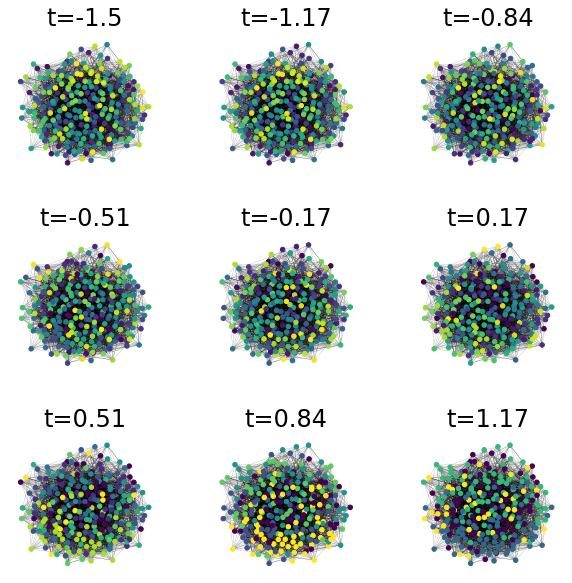

In [16]:
# Get scales
scales = all_results['scales']
log_scales = np.log10(all_results['scales'])
n_scale = all_results["run_params"]["n_scale"]

# Get information about communities
community_id = all_results['community_id']
n_communities  = all_results['number_of_communities']

fig, axes = plt.subplots(3, 3, figsize=(10,10))
fig.subplots_adjust(hspace=0.4, wspace=0.3)

for i, ax in enumerate(axes.flat):
    
    scale = int(i*len(scales)/9)
    
    nx.draw(G, ax=ax,pos=pos, node_size = 20, arrows=False, width = 0.1,
            node_color = community_id[scale])
    ax.set(title=r't={}'.format(np.around(log_scales[scale],2)))
plt.show()

[]


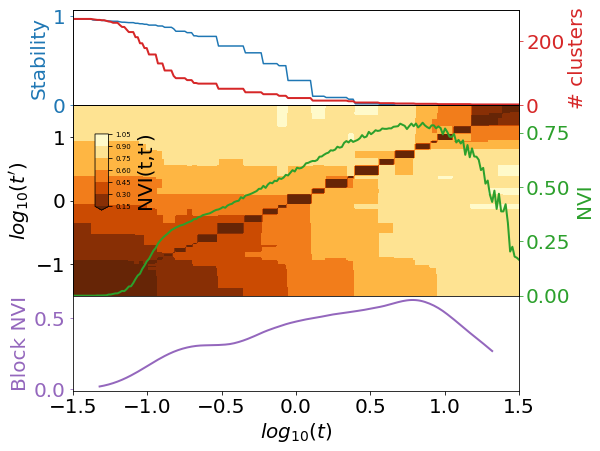

In [17]:
# select optimal scales
identify_optimal_scales(all_results,kernel_size=30,window_size=25)
selected_scales = log_scales[all_results['selected_partitions']]
print(selected_scales)
figure(figsize=(8, 7))
plotting.plot_scan(all_results)
plt.savefig(root_fig +'ER_MS.pdf',bbox_inches='tight')

In [18]:
selected_paritions = all_results['selected_partitions']

n_communities = [len(np.unique(all_results['community_id'][i])) for i in range(len(scales))]

In [19]:
from pygenstability.contrib.sankey import plot_sankey

In [20]:
plot_sankey(all_results)#,optimal_scales=False)

# Persistent homology

In [21]:
# Select optimal scales
msf.select_scales()#threshold_abs=0.13,min_gap_width=0.13,with_plot=True)

In [22]:
msf.optimal_scales

array([], dtype=float64)

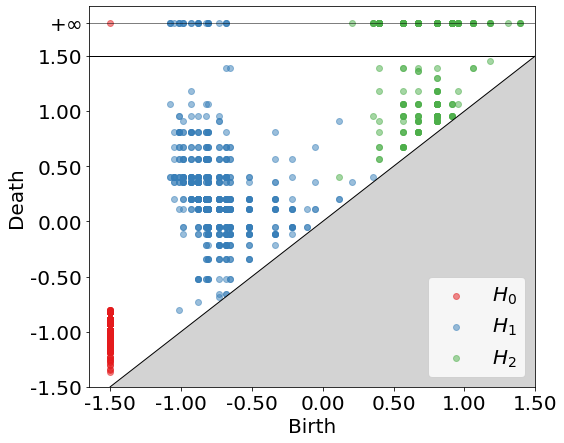

In [23]:
# Plot persistence diagram with optimal scales
ax = msf.plot_persistence_diagram()
plt.savefig(root_fig +'ER_PD.pdf', dpi=fig.dpi,bbox_inches='tight')

# Analyse hierarchy of partitions using $\beta_0$

In [24]:
from msfiltration.msf_properties import compute_rank, compute_beta_0

In [25]:
rank = compute_rank(msf)
beta_0 = compute_beta_0(msf)

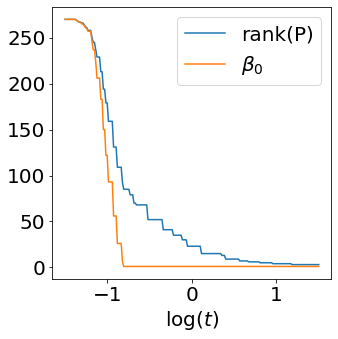

In [26]:
fig, ax = plt.subplots(1, figsize=(5, 5))
ax.plot(msf.log_scales,rank, label = 'rank(P)')
ax.plot(msf.log_scales,beta_0[:-1], label = r'$\beta_0$')
ax.set(xlabel=r'$\log(t)$')
ax.legend()
#plt.show()
plt.savefig(root_fig +'ER_beta0.pdf', dpi=fig.dpi,bbox_inches='tight')

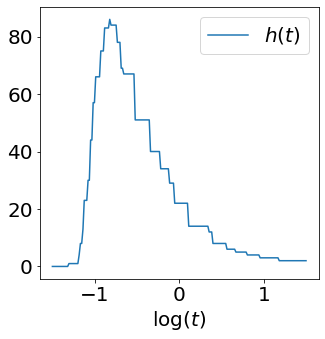

In [27]:
fig, ax = plt.subplots(1, figsize=(5, 5))
ax.plot(msf.log_scales,(rank-beta_0[:-1]), label = r'$h(t)$')
ax.set(xlabel=r'$\log(t)$')
ax.legend()
plt.savefig(root_fig +'ER_persistent_hierarchy.pdf', dpi=fig.dpi,bbox_inches='tight')
plt.show()

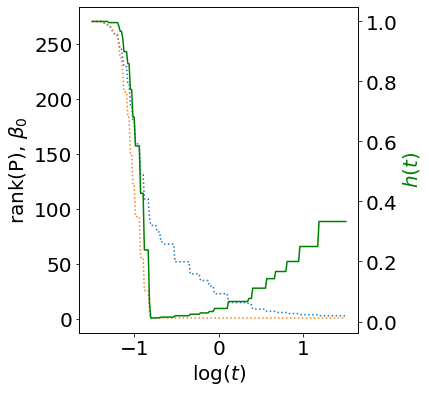

In [28]:
fig, ax1 = plt.subplots(1, figsize=(5, 6))
ax1.plot(msf.log_scales,rank, label = 'rank(P)',ls=':')
ax1.plot(msf.log_scales,beta_0[:-1], label = r'$\beta_0$',ls=':')
ax1.set(xlabel=r'$\log(t)$',ylabel=r'rank(P), $\beta_0$')
handles1, labels = plt.gca().get_legend_handles_labels()
ax2 = ax1.twinx()
ax2.plot(msf.log_scales,beta_0[:-1]/rank, label = r'$h(t)$',c='green')
ax2.set_ylabel(r'$h(t)$', color="green")
#ax2.tick_params("y", colors="green")
handles2, labels = plt.gca().get_legend_handles_labels()
# ax.legend()
# ax2.legend()
#plt.legend(handles=handles1+handles2)
#plt.show()
plt.savefig(root_fig +'ER_persistence_hierarchy.pdf', dpi=fig.dpi,bbox_inches='tight')

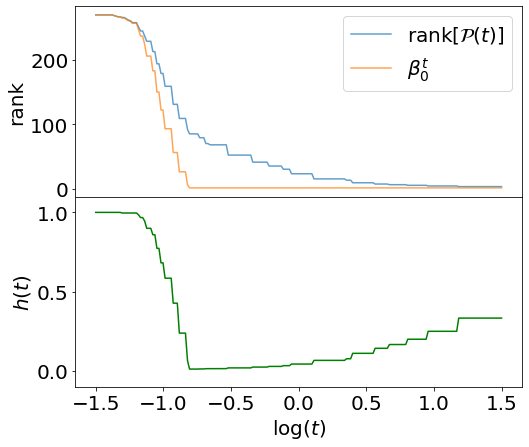

In [29]:
fig, axs = plt.subplots(2, figsize=(8, 7))
fig.subplots_adjust(hspace=0.0, wspace=0.3)
ax1 = axs[0]
ax2 = axs[1]
ax1.plot(msf.log_scales,rank, label = r'rank$[\mathcal{P}(t)]$',alpha=0.7)#,ls=':')
ax1.plot(msf.log_scales,beta_0[:-1], label = r'$\beta_0^t$',alpha=0.7)#,ls=':')
ax1.set(xticks=[],ylabel=r'rank')

ax1.legend()

ax2.plot(msf.log_scales,beta_0[:-1]/rank, label = r'$h(t)$',c='green')
ax2.set_ylabel(r'$h(t)$')#, color="green")
ax2.set(xlabel=r'$\log(t)$',ylim=(-0.1,1.1))
plt.savefig(root_fig +'ER_persistence_hierarchy.pdf', dpi=fig.dpi,bbox_inches='tight')